In [408]:
import numpy as np
import pylab as pl
import os
import sys
import maxflow
from tifffile import *

from skimage.filters import gaussian_filter

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (5, 5)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Constants and Parameters

In [507]:
pylab.rcParams['figure.figsize'] = (5, 5)

INF = 100000
# filename = "triangle2d.tif"

# filename = "potatoe2d.tif"
# filename = "potatoe2d_2.tif"
# filename = "potatoe2d_3.tif"

# filename = "ellipse2d.tif"
# filename = "ellipse2d_2.tif"
# filename = "ellipse2d_3.tif"
filename = "ellipse2d_4.tif"

# filename = "gradient2d_plus.tif"

# sampling parameters
num_columns = 25
num_neighbors = 2
K = 30                  # as in Wu & Chen 2002

# net surface related parameters
max_delta_k = 4

# positioning of net in image
center_x = 55
center_y = 35
max_r = 40
delta_k = max_r / float(K)

### Loading image to be segmented...

In [508]:
sigma = 2.
image = imread(filename)
image_smooth = gaussian_filter(image,sigma)

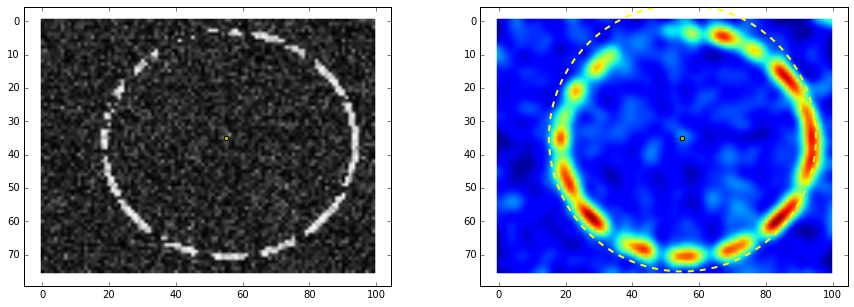

In [523]:
fig = plt.figure(figsize=(5,10))
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image, plt.get_cmap('gray'))
axarr[0].scatter(center_x,center_y, c='y', marker='o')
axarr[1].imshow(image_smooth)
axarr[1].scatter(center_x,center_y, c='y', marker='o')
circle = plt.Circle((center_x,center_y),radius=max_r,fill=False,color='yellow', lw=2.0, ls='--')
plt.gca().add_patch(circle)

### Create vectors and neighborhoods to prepare building the graph

In [510]:
def sample_circle( n=18 ):
    '''
        Returns n many points on the unit circle (equally spaced).
    '''
    points = np.zeros([n,2])
    for i in range(n):
        angle = 2*math.pi * i/float(n)
        x = cos(angle)
        y = sin(angle)
        # print angle, x, y
        points[i] = [x,y]
        
    return points

In [511]:
col_vectors = sample_circle(num_columns)
neighbors=[]
neighbors_of = np.ones([num_columns,num_neighbors]) * -1
for i,p1 in enumerate(col_vectors):
    dists = []
    for j,p2 in enumerate(col_vectors):
        dists.append( [i, j, np.dot(p1,p2)] )
    sorted_dists = sorted(dists, key=lambda dists: -dists[2])
    for idx in range(1,1+num_neighbors):
        neighbors.append(sorted_dists[idx])
    for idx in range(num_neighbors):
        neighbors_of[i,idx] = sorted_dists[idx+1][1]

# print neighbors_of

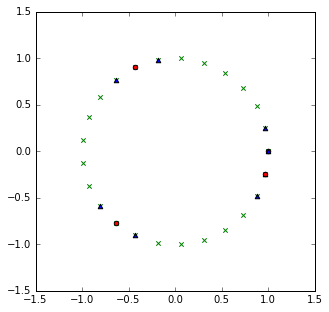

In [512]:
fig = plt.figure()
plt.scatter(col_vectors[:,0],col_vectors[:,1], c='g', marker='x')
for cidx in range(0,num_columns,num_columns/3):
    cx = col_vectors[cidx,0]
    cy = col_vectors[cidx,1]
    plt.scatter(cx, cy, c='r', marker='o')

    nOfC = neighbors[cidx*num_neighbors:(cidx+1)*num_neighbors]
    p = col_vectors[[nOfC[i][1] for i in range(num_neighbors)]]
    xs = p[:,0]
    ys = p[:,1]
    plt.scatter(xs, ys, c='b', marker='^')

# Build Graph

### _Helper functions..._

In [513]:
def get_bresenham_coordinates(start, end):
    """
    Bresenham's Line Algorithm
    Produces a list of tuples from start and end
 
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points
    

In [514]:
def compute_weight( img, coords ):
    m = 0
    for c in coords:
        try:
            m = max(m,img[c[::-1]]) # [::-1]
        except:
            None
    return m
        
#test_coords = [(50,50),(80,90),(50,52)]
#compute_weight( image, test_coords)

### Compute all weights w

In [515]:
w = np.zeros([num_columns, K]) # node weights
w_tilde = np.zeros([num_columns, K])

# fill in node weights
for i in range(num_columns):
    to_x = int(center_x + col_vectors[i,0]*max_r)
    to_y = int(center_y + col_vectors[i,1]*max_r)
#     print center_x, center_y, to_x, to_y
    coords = get_bresenham_coordinates( (center_x, center_y), (to_x, to_y))
    num_pixels = len(coords)
    for k in range(K):
        start = int(k * float(num_pixels)/K)
        end = start + num_pixels/K
        w[i,k] = -1 * compute_weight( image_smooth, coords[start:end]) # _smooth
        
for i in range(num_columns):
    w_tilde[i,0] = w[i,0] 
    for k in range(1,K):
        w_tilde[i,k] = w[i,k]-w[i,k-1]

# print w
# print w_tilde

### Build flow network

In [516]:
num_nodes = num_columns*K
num_edges = (num_nodes*num_neighbors*(max_delta_k+max_delta_k+1))/2

g = maxflow.Graph[float](num_nodes,num_edges)
nodes = g.add_nodes(num_nodes)

for i in range(num_columns):

    # connect column to s,t
    for k in range(K):
        if w_tilde[i,k] < 0:
            g.add_tedge(i*K+k, -w_tilde[i,k], 0)
        else:
            g.add_tedge(i*K+k, 0, w_tilde[i,k])
            
    # connect column to i-chain
    for k in range(1,K):
        g.add_edge(i*K+k, i*K+k-1, INF, 0)
        
    # connect column to neighbors
    for k in range(K):
        for j in neighbors_of[i]:
            k2 = max(0,k-max_delta_k)
            g.add_edge(i*K+k, j*K+k2, INF, 0)
            # print i,k,int(j),k2

### Solve and show

In [517]:
maxval = g.maxflow()

size_s_comp = 0
size_t_comp = 0
for n in nodes:
    seg = g.get_segment(n)
    if seg == 0:
        size_s_comp += 1
    else:
        size_t_comp += 1
    #print "Segment of the node ",n,":", seg
print "Size of s and t component: ", size_s_comp, size_t_comp


Size of s and t component:  677 73


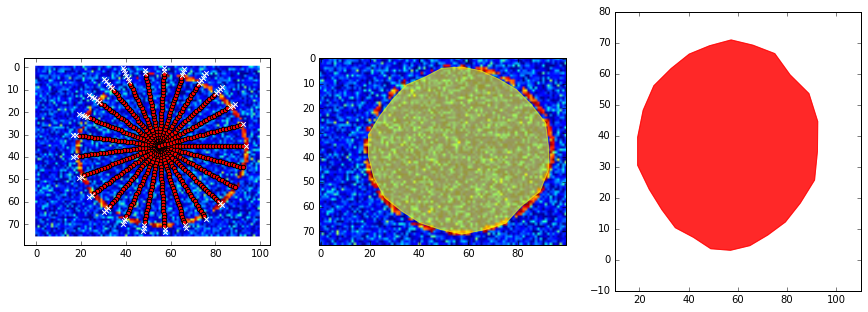

In [518]:
pylab.rcParams['figure.figsize'] = (15, 5)
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()
ax = plt.subplot(131)
ax.imshow(image)

patches = [] # collects patches to be plotted
surface=[] # will collect the highest v per column in here
for i in range(num_columns):
    surface.append((0,0))
    for k in range(K):
        x = center_x + col_vectors[i,0] * k/float(K) * max_r
        y = center_y + col_vectors[i,1] * k/float(K) * max_r
        seg = g.get_segment(i*K+k)
        if seg == 0:
            surface[i] = (x,y)
            if x>=0 and y>=0 and x<shape(image)[1] and y<shape(image)[0]:
                ax.scatter(x,y, c='r', marker='o')
        if seg == 1:
            if x>=0 and y>=0 and x<shape(image)[1] and y<shape(image)[0]:
                ax.scatter(x,y, c='w', marker='x')

ax = plt.subplot(132)
plt.imshow(image)
polygon = Polygon(surface, True)
patches.append(polygon)
p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.6, color='yellow')
ax.add_collection(p)

ax = plt.subplot(133)
polygon = Polygon(surface, True)
patches.append(polygon)
p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.6, color='red')
# plt.gca().invert_yaxis()
ax.add_collection(p)
ax.scatter(99,74, c='w', marker='x')